# PM2.5浓度估计

**目标：**


1.   使用深度神经网络(Deep Neural network, DNN)来解决回归问题
2.   学习基本的DNN训练方法
3.   熟悉目前主流的深度学习框架Pytorch

本次作业我们提供了训练集、验证集（均带有标签）以及测试集（不带标签），你可以通过训练集和验证集寻找最好的模型，并在测试集上得到你的预测结果。

最后你需要将预测结果提交到kaggle上(https://www.kaggle.com/competitions/ml-dl-2022-hw1/overview), 系统会自动返回给你测试集误差(MSE)。

总的来说，本次作业的目标就是基于我们给定的代码，发挥你在课堂上学习到的知识，修改代码，从而得到尽可能低的**测试集**误差。




## 研究准备

### 下载数据
在这里，我们从google drive上下载本次作业需要的数据,包括train.csv, val.csv, test.csv

下载完成后，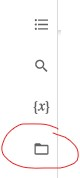点击左边此处可以找到三个csv文件，双击文件可以预览其结构，其中，每一行为一个观测数据，每一列为一个特征，具体地：

station：站点编号

date:数据采集日期

lat、lon：站点经纬度

AOD:气溶胶光学厚度

ET：蒸发量

BLH:边界层高度

TEM：温度

NDVI：植被指数

SP：海平面气压

RH：相对湿度

DEM：地面高程

NTL：夜间灯光指数

LUC：土地覆盖类型

PRE: 降水

WS、WD：风速风向

In [ ]:
train_path = 'train.csv'
val_path = 'val.csv'
test_path = 'test.csv'
!gdown --id 15BfpT7ieOq_RaMKz9fZQF1gpQLEu83be --output 'train.csv'
!gdown --id 1w4v26_bRzrIUTKQSTtPl7Klu1XZtZITX --output 'val.csv'
!gdown --id 1KRFj-T2fS_K8-4tOX_pN7ugQNz8bseVn --output 'test.csv'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15BfpT7ieOq_RaMKz9fZQF1gpQLEu83be
To: /content/train.csv
100% 1.72M/1.72M [00:00<00:00, 115MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w4v26_bRzrIUTKQSTtPl7Klu1XZtZITX
To: /content/val.csv
100% 520k/520k [00:00<00:00, 97.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://driv

### 设置环境
接下来，我们导入代码所需要的运行环境

In [ ]:
# 如果你引入了新的库，可以从这里导入
import pandas # 提供dataframe，用来处理csv数据
import torch # pytorch，目前主流的深度学习框架
from torch.utils import data # 从torch.utils导入data模块，用来构建pytorch中的数据结构--->dataloader
from torch import nn # 从torch导入nn模块，用来提供基本的神经网络接口，如全连接层nn.Linear()
import numpy as np # 导入numpy，并将其重命名为np，numpy是一个高效的用来处理矩阵的库
from tqdm import tqdm # tqdm是一个可视化代码进程的模块
import os # os库用来处理磁盘读写过程
from sklearn.preprocessing import StandardScaler # 这是一个用来数据标准化的模块
import csv # 读写csv文件的库
normalize = StandardScaler() # 实例化StandardScaler
# 为了处理大批量数据，在目前主流的深度学习框架下，数据都是以矩阵的形式表示的
# 而对于CPU来讲，其对于矩阵数据处理效率欠佳，而GPU(显卡）则擅长处理矩阵，因此深度学习模型都会部署到GPU上
# 这段代码的意思是，判断目前的设备中是否有安装CUDA（GPU加速模块）。
# 如果有的话，我们就让模型部署到GPU上，如果没有，我们继续用CPU（速度会慢一点）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


## 进行实验

### 构建数据

In [ ]:
# 这段代码用来创建pytorch所需的基本数据结构，data.Dataset
class PM2_5Dataset(data.Dataset):
  def __init__(self, csv_path, mode="train"):
      super(PM2_5Dataset, self).__init__()
      self.csv_content = pandas.read_csv(csv_path)
      self.used_column = ["AOD", "ET", "BLH", "TEM", "NDVI", "SP", "RH", "DEM", "NTL", "PRE", "WS", "WD"] # TODO：这些特征都是有用的吗？修改这行代码，可以修改模型输入的特征
      self.target_column = "PM2.5" 
      self.mode = mode
      self.dim = len(self.used_column)
      if mode in ["train", "val"]:
          self.input_data, self.target_data = self.process_csv_with_gt()

      else:
          self.input_data = self.process_csv_without_gt()

  def process_csv_with_gt(self):
      input_data = [list(self.csv_content[i]) for i in self.used_column]
      input_data = np.array(input_data)
      input_data = input_data.T
      input_data = normalize.fit_transform(input_data)
      target_data = np.array(self.csv_content[self.target_column])
      return input_data, target_data

  def process_csv_without_gt(self):
      input_data = [list(self.csv_content[i]) for i in self.used_column]
      input_data = np.array(input_data)
      input_data = input_data.T
      input_data = normalize.fit_transform(input_data) 
      return input_data

  def __getitem__(self, index):
      if self.mode in ["train", "val"]:
          data, gt = self.input_data[index, :], self.target_data[index]
          data = torch.from_numpy(data)
          gt = torch.tensor(gt)
          return data, gt
      else:
          data = self.input_data[index, :]
          return torch.from_numpy(data)

  def __len__(self):
      return self.input_data.shape[0]

def prepare_dataset(csv_path, batch_size, mode):
  dataset = PM2_5Dataset(csv_path, mode)
  # 在pytorch中，dataset需要用dataloader封装
  if mode in ["train", "val"]:
      dataloader = data.DataLoader(dataset, batch_size, num_workers=0, pin_memory=True)
  else:
      dataloader = data.DataLoader(dataset, 1, num_workers=0, pin_memory=True, shuffle=False)
  return dataloader


### 构建模型

In [ ]:
# 这是一个基本的神经网络模型，包含三个全连接层，激活函数为Relu
class MyNeuralNet(nn.Module):
  # TODO：增加约束，如添加dropput，batchnorm等。增删全连接层数。修改神经元数量。修改连接方式等。
  def __init__(self, input_dim):
      super(MyNeuralNet, self).__init__()
      self.net = nn.Sequential(
          nn.Linear(input_dim, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1),
      )

  def forward(self, input):
      predict = self.net(input)
      return predict


### 训练、验证与测试
这部分提供了训练、测试、验证的代码，你可以修改。例如修改训练代码部分的损失函数，测试代码中的推理策略(boosting，bagging），将验证集并入到训练集中一起训练，等

In [ ]:
def train(train_dataset, val_dataset, config, model):
  """训练代码"""
  n_epochs = config['n_epochs'] # 训练次数
  optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas']) # 优化器
  model.train() # 设置模型为训练模式（梯度可以回传）
  pbar = tqdm(total=n_epochs, desc="Train Mode", unit="epoch") 
  loss = nn.MSELoss() # 损失函数为MSE(均方误差)
  loss_log = {"train_loss": [], "val_loss": []} 
  min_mse = 1e16
  for epoch in range(n_epochs):
      pbar.update()
      epoch_mse = 0.0
      for x, y in train_dataset:
          optimizer.zero_grad() # 将优化器里储存的梯度清零
          x, y = x.to(device).float(), y.to(device).float()
          y = y.unsqueeze(1) 
          pred = model(x) 
          mse_loss = loss(pred, y) # 计算损失
          mse_loss.backward() # 损失回传
          optimizer.step() # 梯度更新
          loss_log["train_loss"].append(mse_loss.detach().cpu().item())
          epoch_mse += mse_loss.detach().cpu().item()
      pbar.set_postfix(epoch=epoch + 1, mse=epoch_mse / len(train_dataset))
      val_mse = val(val_dataset, model)
      if val_mse < min_mse:
          min_mse = val_mse
          torch.save(model.state_dict(), config['save_path'])
          print(f"best model saved! val mse:{val_mse},epoch:{epoch + 1}")
      loss_log["val_loss"].append(val_mse)
  return min_mse, loss_log
def val(val_dataset, model):
  """验证代码"""
  model.eval() # 设置为验证模式（梯度不回传）
  total_loss = 0
  loss = nn.MSELoss()
  for x, y in val_dataset:
      x, y = x.to(device).float(), y.to(device).float()
      y = y.unsqueeze(1)
      with torch.no_grad():
          pred = model(x) # 预测结果
          mse_loss = loss(pred, y) # 计算损失
      total_loss += mse_loss.detach().cpu().item()
  total_loss = total_loss / len(val_dataset)
  return total_loss


def test(test_set, model):
  """测试代码"""
  model.eval() #
  preds = []
  for x in test_set:
      x = x.to(device).float()
      with torch.no_grad():
          pred = model(x)
          preds.append(pred.detach().cpu())
  return preds

### 处理预测结果

In [ ]:
# 这部分不需要修改
def process_preds_to_csv(preds):
  with open("MyPred.csv", "w", newline='') as f:
      writer = csv.writer(f)
      writer.writerow(['id', 'PM2.5'])
      for i, p in enumerate(preds):
          p = p.cpu().item()
          writer.writerow([i, p])

### 主程序

In [ ]:
model = None
os.makedirs('models', exist_ok=True)
# 模型超参数设置
config = {
    'n_epochs': 200,  # 训练次数
    'batch_size': 128,  # mini-batch 的大小 
    'optimizer': 'SGD',  # 优化算法 (optimizer in torch.optim) 
    'optim_hparas': {  # 优化器的超参数(取决于你用了什么优化算法)
        'lr': 0.001,
        'momentum':0.9                # SGD的学习率  # SGD的动量
    },
    'save_path': 'models/model.pth'  # 存储路径
}
# 构建dataset
train_dataset = prepare_dataset(r"train.csv", config["batch_size"], mode="train") 
val_dataset = prepare_dataset(r"val.csv", config["batch_size"], mode="val")
test_dataset = prepare_dataset(r"test.csv", config["batch_size"], mode="test")
# 实例化模型
model = MyNeuralNet(train_dataset.dataset.dim).to(device)
# 开始训练与验证
min_mse, loss_log = train(train_dataset, val_dataset, config, model)
# 测试模型
preds = test(test_dataset, model)
# 将测试的结果保存到CSV文件里
process_preds_to_csv(preds)
# 执行完成后，可以从左侧下载预测结果(MyPred.csv)，并将其提交到Kaggle上，Kaggle会反馈给你测试集的评分（MSE）


Train Mode:   1%|          | 2/200 [00:00<00:23,  8.53epoch/s, epoch=1, mse=673]


best model saved! val mse:687.7400957743326,epoch:1


Train Mode:   2%|▏         | 3/200 [00:00<00:34,  5.67epoch/s, epoch=2, mse=439]


best model saved! val mse:424.2332191467285,epoch:2


Train Mode:  12%|█▏        | 23/200 [00:05<00:47,  3.75epoch/s, epoch=22, mse=340]

best model saved! val mse:422.3498725891113,epoch:22



Train Mode:  12%|█▏        | 24/200 [00:05<00:47,  3.71epoch/s, epoch=23, mse=337]

best model saved! val mse:417.58240636189777,epoch:23



Train Mode:  12%|█▎        | 25/200 [00:06<00:47,  3.67epoch/s, epoch=24, mse=338]


best model saved! val mse:415.9144922892253,epoch:24


Train Mode:  14%|█▎        | 27/200 [00:06<00:47,  3.63epoch/s, epoch=26, mse=334]

best model saved! val mse:410.31239827473956,epoch:26



Train Mode:  22%|██▏       | 43/200 [00:10<00:38,  4.07epoch/s, epoch=42, mse=307]

best model saved! val mse:410.2173728942871,epoch:42



Train Mode:  22%|██▏       | 44/200 [00:11<00:39,  3.99epoch/s, epoch=44, mse=304]

best model saved! val mse:399.73748270670575,epoch:43



Train Mode:  24%|██▎       | 47/200 [00:12<00:40,  3.79epoch/s, epoch=47, mse=304]

best model saved! val mse:396.26459248860675,epoch:46



Train Mode:  24%|██▍       | 48/200 [00:12<00:39,  3.89epoch/s, epoch=48, mse=298]

best model saved! val mse:388.1736437479655,epoch:47



Train Mode: 100%|██████████| 200/200 [00:48<00:00,  4.11epoch/s, epoch=200, mse=188]


## 可视化
接下来我们可视化一下训练和验证过程中，损失（MSE）的变化情况。

以及我们最终预测结果和真实值之间的分布情况。

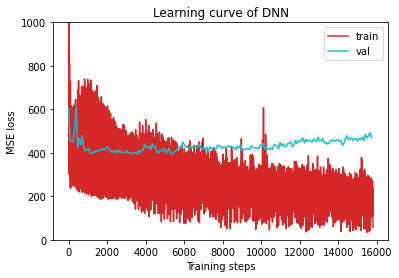

Train Mode:  11%|█         | 109/1000 [16:12<2:12:33,  8.93s/epoch, epoch=109, mse=795]


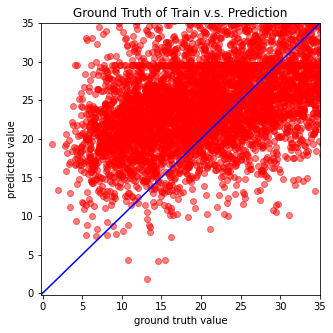

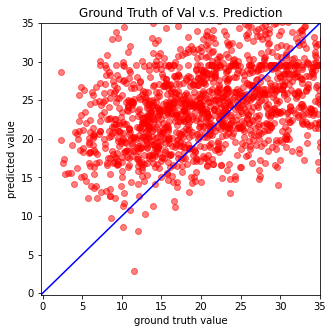

In [ ]:
import matplotlib.pyplot as plt # 用来绘制曲线
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title=''):
  ''' 绘制损失函数曲线 '''
  total_steps = len(loss_record['train_loss'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train_loss']) // len(loss_record['val_loss'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record['train_loss'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['val_loss'], c='tab:cyan', label='val')
  plt.ylim(0.0, 1000.)
  plt.xlabel('Training steps')
  plt.ylabel('MSE loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

def plot_pred(dv_set, model, device, lim=35., title="", preds=None, targets=None):
    ''' 绘制你的预测结果和真实结果之间的分布情况 '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x.float())
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title(title)
    plt.show()


plot_learning_curve(loss_log,"DNN")

plot_pred(train_dataset,model,device,35., 'Ground Truth of Train v.s. Prediction')

plot_pred(val_dataset,model,device,35.,'Ground Truth of Val v.s. Prediction')

## 你需要做什么

**基本要求**


*   弄明白这些代码都在干什么

*   代码中有一处小错误，你能找出来吗（提示：构建数据部分的特征标准化)


**中等要求**


*   特征选择：我们使用了csv文件中提供的所有特征用来预测pm2.5，他们都是有用的吗？如果只用部分特征会不会更好？为什么呢？


*   参数调整：在主程序中，有一个config变量，它存储了我们的很多超参数，如learning rate，batch size等，调整他们会改进模型的精度吗。关于优化器(optimizer)，我们使用的是SGD（随机梯度下降)，有没有其它的优化器可以使用呢，这些优化器里的超参数（如momentum）需要怎么设置呢？


*   L2标准化：训练过程中，让模型的神经元的权值波动不要过大会提高模型的泛化性能，L2标准化是对模型神经元的权值的惩罚项。

**终极要求**

*   模型修改：更深的神经网络,更多的神经元会带来更好的效果吗？有没有什么办法对抗过拟合(如dropout，batchnorm)？

*   地理位置与时间：地理位置(lon,lat),以及时间信息(date)会提升PM2.5的估计精度吗？如果可以的话，该怎么使用它们呢？

*   其它：发挥你的想法，尽可能地减小测试集误差，并解释为什么





